In [62]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.linalg import eig_banded, eig, eigh
from scipy.sparse.linalg import eigsh, eigs
from scipy.sparse import diags, lil_matrix, csr_matrix
import time
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg
from scipy.linalg import solve


### 1. Eigenmodes of drums or membranes of different shapes

#### A. (1 point) 
Discretize eq. (6). Formulate a matrix version of the eigenvalue problem, taking the boundary conditions into account. Hint: draw a small example, number the elements and think about which elements are connected and which are not. Draw a figure showing the discretization points and their positions. Show and explain the shape of the matrix for a very small problem, maybe a 4x4 system.

#### Discretization:
For a general $n \times n$ grid, when formulating the matrix equation $Mv = Kv$ to solve the eigenvalue problem for $\nabla^2v = Kv$, we must consider a larger matrix $M$ and a vector $v$ that represents the values of $v(x,y)$ at all interior points, excluding the boundary. We have a square grid where each interior point is connected to its four nearest neighbors (left, right, up, and down), and the boundary conditions ensure $v(x, y) = 0$ at the edge of the grid.

Given a grid of size $n \times n$, we have $(n-2) \times (n-2)$ interior points due to the exclusion of the boundary. The matrix $M$ will therefore be of size $[(n-2)^2 \times (n-2)^2]$ to account for all interior points.

The Laplacian $\nabla^2v$ at an interior point, using a finite difference approximation with uniform grid spacing $\Delta x = \Delta y$, is:

$
\nabla^2 v(x_i, y_j) \approx \frac{v_{i+1,j} + v_{i-1,j} + v_{i,j+1} + v_{i,j-1} - 4v_{i,j}}{\Delta x^2}
$

#### Matrix Formulation:

Each row of matrix $M$ corresponds to an equation derived from the discretization of the Laplacian at an interior point. - The diagonal elements of $M$ will be $-4/\Delta x^2$, reflecting the $-4v_{i,j}$ term.
- The entries immediately adjacent to the main diagonal (to the left and right) are $1/\Delta x^2$, representing interactions between horizontal neighbors. 
- For interactions between vertical neighbors, we skip $(n-2)$ elements from a diagonal element to reach the next row or column in the matrix, filling in $1/\Delta x^2$. 
- All other entries are $0$, indicating no direct interaction between those points under the finite difference approximation of the Laplacian.

The vector $v$ is a linear arrangement of the values at the interior grid points, stacked row by row.

#### Example for a 4x4 matrix:

For a 4x4 grid with fixed boundaries, if we consider only the interior points for $v$, we get a 2x2 grid of points labeled as $v_{1,1}$, $v_{1,2}$, $v_{2,1}$, $v_{2,2}$

Since each point is connected to its immediate neighbors, the matrix $M$ for this simplified case, assuming $\Delta x^2 = 1$ for simplicity, looks like this:

$
M = \begin{bmatrix}
-4 & 1 & 1 & 0 \\
1 & -4 & 0 & 1 \\
1 & 0 & -4 & 1 \\
0 & 1 & 1 & -4
\end{bmatrix}
$

And the vector $v$ of size $n^2$ would be:

$
v = \begin{bmatrix}
v_{1,1} \\
v_{1,2} \\
v_{2,1} \\
v_{2,2}
\end{bmatrix}
$

### B. (3 points) 
Consider the following three shapes. 1. a square with side length L  
2. a rectangle with sides L and 2L  
3. a circle with diameter L  
Solve the eigenvalue problem. Try scipy.linalg.eig(), eigh() or eigs(), (or something else). Which did you use, and why? Plot the eigenvectors v for some of the smallest eigenvalues, for L = 1. Label the plots with their frequencies.

#### Python Methods:

| Method| Description|
|-------------------------------------|-----------------------------------------------------|
| `scipy.linalg.eig()`                | Computes eigenvalues and eigenvectors of a general (possibly non-symmetric) square dense matrix.                                 |
| `scipy.linalg.eigh()`               | Optimized for Hermitian or real symmetric matrices.                                                                              |
| `scipy.sparse.linalg.eigs()`        | Finds a subset of eigenvalues and eigenvectors of large, sparse, non-symmetric matrices.                                         |
| `scipy.sparse.linalg.eigsh()`       | Similar to `eigs()` but optimized for Hermitian or real symmetric sparse matrices.                                               |
| `scipy.linalg.eigh_tridiagonal()`   | Finds eigenvalues and eigenvectors of tridiagonal matrices.                                                                      |
| `scipy.sparse.linalg.lobpcg()`      | An iterative algorithm for finding the largest eigenvalues and corresponding eigenvectors of large sparse symmetric positive definite matrices. |
| `scipy.linalg.eig_banded()`         | Finds eigenvalues and eigenvectors of banded matrices, efficiently using their structure but not specifically leveraging sparsity.|

- **LAPACK** (Linear Algebra PACKage) is widely used for solving linear algebra problems. It's highly optimized for dense matrices and is the backbone for many `scipy.linalg` functions.
  
- **ARPACK** (ARnoldi PACKage) is designed for solving large-scale eigenvalue problems, especially those involving sparse matrices. It's particularly useful for finding a subset of eigenvalues and eigenvectors, and is used by `scipy.sparse.linalg`.

In [2]:
def create_sparse_matrix(N):
    size = (N-2)**2
    diagonals = -4 * np.ones(size)
    off_diags = np.ones(size-1)
    far_off_diags = np.ones(size-(N-2))
    M = diags([diagonals, off_diags, off_diags, far_off_diags, far_off_diags], [0, -1, 1, -(N-2), (N-2)], format="csr")
    return M

grid_sizes = [10, 50, 100]
eig_times, eigh_times, eigs_times, eigsh_times = [], [], [], []

for N in grid_sizes:
    M_sparse = create_sparse_matrix(N)
    M_dense = M_sparse.toarray()

    # eig
    start = time.time()
    eig(M_dense)
    eig_times.append(time.time() - start)
    print("1")
    # eigh
    start = time.time()
    eigh(M_dense)
    eigh_times.append(time.time() - start)
    print("2")

    # eigsh - Computing 6 eigenvalues of smallest magnitude
    start = time.time()
    eigs(M_sparse, k=6, which='SM')
    eigs_times.append(time.time() - start)
    print("3")

    # eigsh - Computing 6 eigenvalues of smallest magnitude
    start = time.time()
    eigsh(M_sparse, k=6, which='SM')
    eigsh_times.append(time.time() - start)
    print("4")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grid_sizes, eig_times, marker='o', linestyle='-', label='eig')
plt.plot(grid_sizes, eigh_times, marker='s', linestyle='-', label='eigh')
plt.plot(grid_sizes, eigs_times, marker='^', linestyle='-', label='eigs (6 eigenvalues)')
plt.plot(grid_sizes, eigsh_times, marker='x', linestyle='-', label='eigsh (6 eigenvalues)')
plt.xlabel('Grid Size (N)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of eig, eigh, eigs, and eigsh')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


1
2
3
4
1
2
3
4


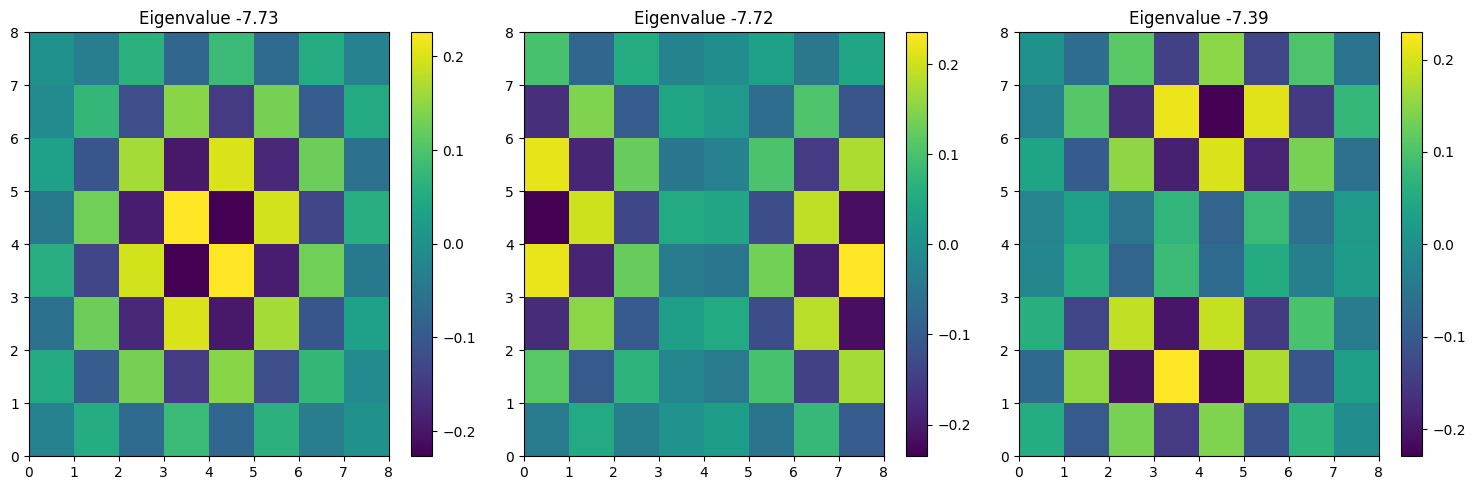

In [29]:
N = 10  # Size of the grid including boundaries
M = create_sparse_matrix(N).toarray()
eigenvalues, eigenvectors = eigh(M)

# Correct the reshape dimensions to match the size of the interior grid
interior_size = N - 2  # Subtracting the boundaries

# Plot the first few eigenvectors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    eigenvector = eigenvectors[:, i].reshape((interior_size, interior_size))
    c = ax.pcolormesh(eigenvector, cmap='viridis')
    fig.colorbar(c, ax=ax)
    ax.set_title(f'Eigenvalue {eigenvalues[i]:.2f}')
plt.tight_layout()
plt.show()


#### Direct Methods for steady state Diffusion

The discretization of the diffusion equation in a circular domain involves constructing a matrix equation of the form $M\mathbf{c} = \mathbf{b}$, where $M$ is the discretized Laplacian matrix, $\mathbf{c}$ is the vector of unknown concentration values at grid points within the domain, and $\mathbf{b}$ is the source term vector. The construction of $M$ and $\mathbf{b}$ is detailed below:

#### Grid Discretization
Given a circular domain of radius $R$ and a grid spacing $\Delta x$, the domain is discretized into a square grid of size $L \times L$, where $L = \frac{2R}{\Delta x} + 1$. Each grid point $(i,j)$ corresponds to a physical position $(x_i, y_j)$, with $x_i = i\Delta x - R$ and $y_j = j\Delta x - R$. Only the points $(i,j)$ for which $x_i^2 + y_j^2 \leq R^2$ are considered to be inside the circular domain.

#### Construction of $M$
The matrix $M$ represents the discretized Laplacian operator $\nabla^2$, applied to the concentration field within the domain. For a uniform grid with spacing $\Delta x$, the second derivative in two dimensions can be approximated by the central difference formula:

$\nabla^2 c \approx \frac{c_{i+1,j} + c_{i-1,j} + c_{i,j+1} + c_{i,j-1} - 4c_{i,j}}{\Delta x^2}$

For each grid point $(i,j)$ inside the domain, a row in $M$ is created with entries corresponding to the coefficients of $c_{i,j}$ and its neighbors. Specifically, $M_{k,k} = -4$ for the central point, and $M_{k,k'} = 1$ for each of the four neighboring points, where $k$ and $k'$ are the indices in the vectorized form of the concentration field $\mathbf{c}$. Points outside the domain or on the boundary are excluded from the matrix.

#### Construction of $\mathbf{b}$
The vector $\mathbf{b}$ represents the source term of the diffusion equation. For a source located at a specific point $(x_s, y_s)$ within the domain, the corresponding grid point $(i_s, j_s)$ is identified, and the source value is placed in the vector $\mathbf{b}$ at the position corresponding to $(i_s, j_s)$. If $(x_s, y_s)$ corresponds to $(i_s, j_s)$, then $\mathbf{b}_s = 1$ for a unit source, and all other entries in $\mathbf{b}$ are set to $0$.

#### Solution of the Discretized Equation
The discretized diffusion equation is solved by finding the vector $\mathbf{c}$ that satisfies $M\mathbf{c} = \mathbf{b}$. This linear system of equations is solved using numerical methods appropriate for sparse matrices, as the matrix $M$ is sparse due to the nature of the discretization.

#### Python Methods:

| Method| Description|
|-------------------------------------|-----------------------------------------------------|
| `scipy.linalg.solve()`              | Solves a linear matrix equation, or system of linear scalar equations, for square matrices.                                 |
| `scipy.sparse.linalg.spsolve()`     | Solves a sparse linear matrix equation, providing a solution to Ax = b where A is a sparse matrix.                                                                             |
| `scipy.sparse.linalg.cg()`          | Solves a linear matrix equation using the Conjugate Gradient iterative method, typically for symmetric, positive-definite sparse matrices.                                         |



In [65]:
def create_grid(dx, radius):
    """Create a grid and identify points within a circular domain."""
    # Adjusted to create 1D arrays for x and y
    L = int(2 * radius / dx) + 1
    x = np.linspace(-radius, radius, L)
    y = np.linspace(-radius, radius, L)
    xv, yv = np.meshgrid(x, y)
    mask = xv**2 + yv**2 <= radius**2
    return x, y, mask

def build_laplacian_matrix_dense(dx, radius, mask):
    """Build the Laplacian matrix with boundary conditions applied to a mask using a dense matrix."""
    L = int(2 * radius / dx) + 1
    N = np.count_nonzero(mask)
    M = np.zeros((N, N)) 
    idx_map = {}
    counter = 0

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                idx_map[(i, j)] = counter
                counter += 1

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if not mask[i, j]:
                continue
            index = idx_map[(i, j)]
            M[index, index] = -4
            for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < mask.shape[0] and 0 <= nj < mask.shape[1] and mask[ni, nj]:
                    M[index, idx_map[(ni, nj)]] = 1
    return M, idx_map

def solve_diffusion_dense(dx, radius, source_pos, source_value):
    """Solve the diffusion equation for a given source and boundary conditions using a dense matrix."""
    # Assumed create_grid is a function provided elsewhere to create the grid and mask
    L = int(2 * radius / dx) + 1
    x, y, mask = create_grid(dx, radius)
    M, idx_map = build_laplacian_matrix_dense(dx, radius, mask)
    b = np.zeros(len(idx_map))
    
    si, sj = int((source_pos[1] + radius) / (2 * radius) * L), int((source_pos[0] + radius) / (2 * radius) * L)
    source_idx = idx_map.get((si, sj), -1)
    if source_idx >= 0:
        b[source_idx] = source_value
    
    # Solve the linear system using scipy.linalg.solve
    c = solve(M, b)
    
    # Map solution back to grid
    c_grid = np.full(mask.shape, np.nan)
    for (i, j), idx in idx_map.items():
        c_grid[i, j] = c[idx]
    
    return x, y, c_grid

def build_laplacian_matrix_sparse(dx, radius, mask):
    """Build the Laplacian matrix with boundary conditions applied to a mask."""
    L = int(2 * radius / dx) + 1
    N = np.count_nonzero(mask)
    M = lil_matrix((N, N))
    idx_map = {}
    counter = 0

    for i in range(L):
        for j in range(L):
            if mask[i, j]:
                idx_map[(i, j)] = counter
                counter += 1
                
    for i in range(L):
        for j in range(L):
            if not mask[i, j]:
                continue
            index = idx_map[(i, j)]
            M[index, index] = -4
            for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                ni, nj = i + di, j + dj
                if ni >= 0 and ni < L and nj >= 0 and nj < L and mask[ni, nj]:
                    M[index, idx_map[(ni, nj)]] = 1
    return M, idx_map

def solve_diffusion(dx, radius, source_pos, source_value):
    """Solve the diffusion equation for a given source and boundary conditions."""
    dx = 0.01  # Grid points per dimension
    L = int(2 * radius / dx) + 1
    x, y, mask = create_grid(dx, radius)
    M, idx_map = build_laplacian_matrix_sparse(dx, radius, mask)
    b = np.zeros(len(idx_map))
    
    si, sj = int((source_pos[1] + radius) / (2 * radius) * L), int((source_pos[0] + radius) / (2 * radius) * L)
    source_idx = idx_map.get((si, sj), -1)
    if source_idx >= 0:
        b[source_idx] = source_value
    
    # Solve the linear system
    c = spsolve(M.tocsr(), b)
    
    # Map solution back to grid
    c_grid = np.full(mask.shape, np.nan)
    for (i, j), idx in idx_map.items():
        c_grid[i, j] = c[idx]
    
    return x, y, c_grid

def solve_diffusion_cg(dx, radius, source_pos, source_value):
    """Solve the diffusion equation for a given source and boundary conditions."""
    dx = 0.01  # Grid points per dimension
    L = int(2 * radius / dx) + 1
    x, y, mask = create_grid(dx, radius)
    M, idx_map = build_laplacian_matrix_sparse(dx, radius, mask)
    b = np.zeros(len(idx_map))
    
    si, sj = int((source_pos[1] + radius) / (2 * radius) * L), int((source_pos[0] + radius) / (2 * radius) * L)
    source_idx = idx_map.get((si, sj), -1)
    if source_idx >= 0:
        b[source_idx] = source_value
    
    # Use an iterative solver to solve the linear system
    M_csr = M.tocsr()  # Convert to CSR format for efficient arithmetic and matrix vector operations
    c, info = cg(M_csr, b)  # cg returns the solution and info about the convergence
    
    if info != 0:
        print("Conjugate Gradient method did not converge.")
    
    # Map solution back to grid
    c_grid = np.full(mask.shape, np.nan)
    for (i, j), idx in idx_map.items():
        c_grid[i, j] = c[idx]
    
    return x, y, c_grid

In [75]:
# Parameters
dx = 0.03  # Grid spacing
radius = 2.0  # Radius of the circular domain
source_pos = (0.6, 1.2)  # Source position
source_value = 1  # Source concentration

# Solve
x, y, c_grid = solve_diffusion_dense(dx, radius, source_pos, source_value)

# Plot
fig, ax = plt.subplots()
X, Y = np.meshgrid(x, y)
contour = ax.contourf(X, Y, c_grid, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax)
# ax.plot(source_pos[0], source_pos[1], 'ro')  # Mark the source
ax.set_title('Steady State Concentration')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Set the limits
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)

# Set the aspect of the plot to be equal
ax.set_aspect('equal', 'box')

# Show the plot
plt.show()


MemoryError: Unable to allocate 7.35 GiB for an array with shape (31413, 31413) and data type float64

#### Runtime Comparisions

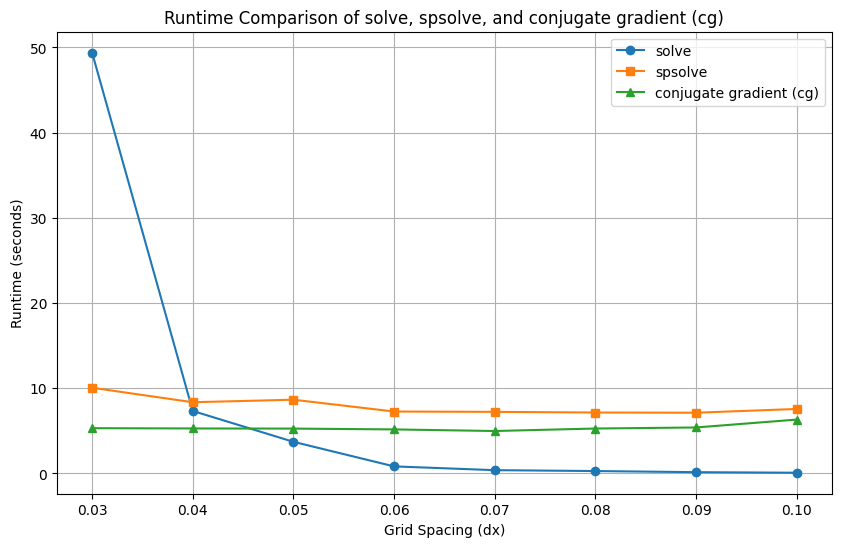

In [78]:
radius = 2.0  # Radius of the circular domain
source_pos = (0.6, 1.2)  # Source position
source_value = 1  # Source concentration
dx_array = [0.03, 0.04, 0.05, 0.06 ,0.07, 0.08, 0.09, 0.1]
# dx_array = [0.07, 0.1]
solve_times, spsolve_times, cg_times = [], [], []

for dx in dx_array:
    # solve
    start = time.time()
    x, y, c_grid = solve_diffusion_dense(dx, radius, source_pos, source_value)
    solve_times.append(time.time() - start)

    # spsolve
    start = time.time()
    x, y, c_grid = solve_diffusion(dx, radius, source_pos, source_value)
    spsolve_times.append(time.time() - start)

    # cg
    start = time.time()
    x, y, c_grid = solve_diffusion_cg(dx, radius, source_pos, source_value)
    cg_times.append(time.time() - start)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dx_array, solve_times, marker='o', linestyle='-', label='solve')
plt.plot(dx_array, spsolve_times, marker='s', linestyle='-', label='spsolve')
plt.plot(dx_array, cg_times, marker='^', linestyle='-', label='conjugate gradient (cg)')
plt.xlabel('Grid Spacing (dx)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of solve, spsolve, and conjugate gradient (cg)')
plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.show()
